In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.init as init
from torch.autograd import Variable
import datetime
from nab_dataset import NabDataset
from models.LVG import LSTMVAEGenerator, LSTMVAEDiscriminator

import matplotlib.pyplot as plt

In [2]:
class ArgsTrn:
    workers=4
    batch_size=128 #original wa 32
    epochs=400 #original was 100
    lr=0.002 #original was 0.0002
    cuda = True
    manualSeed=88

opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)
cudnn.benchmark = True

In [3]:
window_length = 60
hidden_dim = 64
latent_dim = 32

In [4]:
end_name = 'nyc_taxi.csv' # dataset name
data_file = 'data/realKnownCause/'+end_name # dataset category and dataset name
key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels

In [5]:
# settings for data loader
class DataSettings:
    
    def __init__(self):
        self.BASE = '/users/extusr/kaustavprasad/Datasets/NAB/'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = True
        self.window_length = window_length
    
    
data_settings = DataSettings()

In [6]:
# define dataset object and data loader object for NAB dataset
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

dataset.x.shape, dataset.y.shape # check the dataset shape

(torch.Size([10260, 60, 1]), torch.Size([10260]))

torch.Size([128, 60, 1]) torch.Size([128])
torch.Size([128, 60, 1]) torch.Size([128])
torch.Size([128, 60, 1]) torch.Size([128])


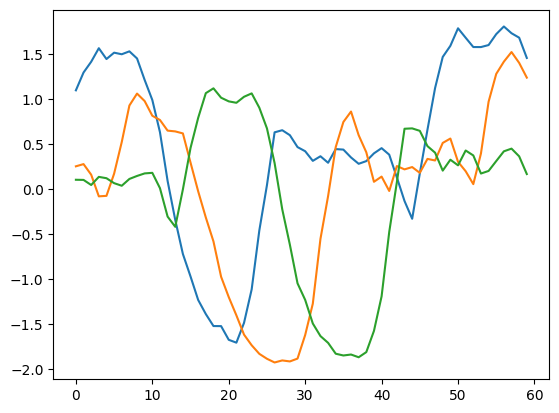

In [7]:
max_index = 3
for i, (x, y) in enumerate(dataloader):
    if i >= max_index: break
    print(x.shape, y.shape)
    plt.plot(x[0, :, 0])




In [8]:
device = torch.device("cuda:0" if opt_trn.cuda else "cpu") # select the device
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature

In [9]:
netG = LSTMVAEGenerator(
    in_dim=in_dim,
    out_dim=in_dim,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    n_layers=1,
    device=device).to(device)

netD = LSTMVAEDiscriminator(
    in_dim=in_dim,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    n_layers=1,
    device=device).to(device)

/users/extusr/kaustavprasad/miniconda3/envs/mlpy/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [10]:
print("|Generator Architecture|\n", netG)
print("|Discriminator Architecture|\n", netD)

|Generator Architecture|
 LSTMVAEGenerator(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (lstm): LSTM(32, 64, batch_first=True, dropout=0.5)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
|Discriminator Architecture|
 LSTMVAEDiscriminator(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (lstm): LSTM(32, 64, batch_first=True, dropout=0.5)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [11]:
criterion = nn.BCELoss().to(device)

In [12]:
optimizerD = optim.Adam(netD.parameters(), lr=opt_trn.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt_trn.lr)

In [13]:

losses_G, losses_D = [], []

In [14]:
verbose = False

real_label = 1
fake_label = 0

for epoch in range(opt_trn.epochs):
    for i, (x,y) in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = x.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        if verbose==True: print("Discriminator input shape:", real.shape)

        output = netD.forward(real)

        if verbose==True: print("Discriminator output shape:", output.shape)


        errD_real = criterion(output, label.float())
        errD_real.backward()
        optimizerD.step()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        
        if verbose==True: print("Noise shape:", noise.shape)
        
        fake = netG.forward(noise)
        
        if verbose==True: print("Generator Output shape:", fake.shape)

        output = netD.forward(fake.detach()) # detach causes gradient is no longer being computed or stored to save memeory
        label.fill_(fake_label)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        fake = netG.forward(noise)
        label.fill_(real_label) 
        output = netD.forward(fake)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()
        D_G_z2 = output.mean().item()
        
        

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
          % (epoch, opt_trn.epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
    
    losses_G.append(errG.item())
    losses_D.append(errD.item())
    print()

/tmp/ipykernel_2835468/2436191795.py:32: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
/tmp/ipykernel_2835468/2436191795.py:52: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()


[0/400][80/81] Loss_D: 0.0591 Loss_G: 3.6537 D(x): 0.9963 D(G(z)): 0.0478 / 0.0448
[1/400][80/81] Loss_D: 0.2618 Loss_G: 3.5029 D(x): 0.9170 D(G(z)): 0.0379 / 0.0406
[2/400][80/81] Loss_D: 0.0254 Loss_G: 5.5681 D(x): 0.9960 D(G(z)): 0.0182 / 0.0179
[3/400][80/81] Loss_D: 0.0517 Loss_G: 4.1917 D(x): 0.9900 D(G(z)): 0.0336 / 0.0330
[4/400][80/81] Loss_D: 0.0239 Loss_G: 6.0677 D(x): 0.9947 D(G(z)): 0.0150 / 0.0144
[5/400][80/81] Loss_D: 0.0170 Loss_G: 7.1567 D(x): 0.9945 D(G(z)): 0.0080 / 0.0080
[6/400][80/81] Loss_D: 0.1037 Loss_G: 3.7447 D(x): 0.9749 D(G(z)): 0.0322 / 0.0318
[7/400][80/81] Loss_D: 0.0160 Loss_G: 5.9443 D(x): 0.9967 D(G(z)): 0.0106 / 0.0106
[8/400][80/81] Loss_D: 0.0561 Loss_G: 4.3155 D(x): 0.9850 D(G(z)): 0.0233 / 0.0244
[9/400][80/81] Loss_D: 0.0117 Loss_G: 6.6853 D(x): 0.9966 D(G(z)): 0.0070 / 0.0069
[10/400][80/81] Loss_D: 0.0189 Loss_G: 7.5109 D(x): 0.9926 D(G(z)): 0.0069 / 0.0073
[11/400][80/81] Loss_D: 0.0094 Loss_G: 8.2051 D(x): 0.9975 D(G(z)): 0.0051 / 0.0050
[1

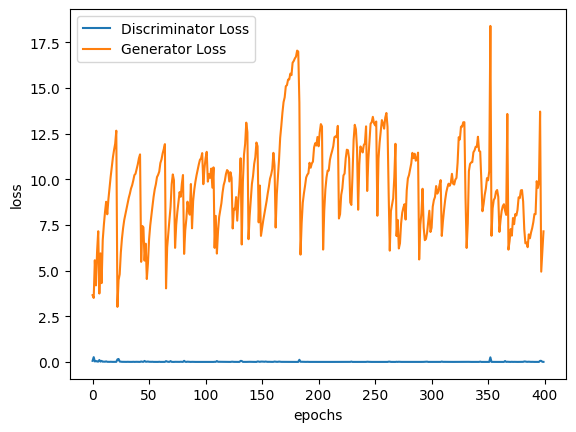

In [15]:
plt.plot(losses_D, label='Discriminator Loss')
plt.plot(losses_G, label='Generator Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
class ArgsTest:
    workers = 1
    batch_size = 1
    z_learning_rate = 0.02
    grad_descent_iterations = 50
    
opt_test=ArgsTest()    

In [17]:
generator = netG 
discriminator = netD

In [18]:
class TestDataSettings:
    
    def __init__(self):
        self.BASE = '/users/extusr/kaustavprasad/Datasets/NAB/'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = False

        
test_data_settings = TestDataSettings()

In [19]:

test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape

(torch.Size([171, 60, 1]), torch.Size([171]), 171)

In [20]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    x_feature = discriminator(x.to(device)) 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    G_z_feature = discriminator(G_z.to(device)) 
    
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

In [21]:
loss_list = []
#y_list = []
for i, (x,y) in enumerate(test_dataloader):
    print(i, y)
    
    z = Variable(init.normal(torch.zeros(opt_test.batch_size,
                                     test_dataset.window_length, 
                                     test_dataset.n_feature),mean=0,std=0.1),requires_grad=True)
    #z = x
    z_optimizer = torch.optim.Adam([z],lr=opt_test.z_learning_rate)
    
    loss = None
    for j in range(opt_test.grad_descent_iterations): # set your interation range
        gen_fake = generator(z.cuda())
        loss = Anomaly_score(Variable(x).cuda(), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    #y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y={} ~~~~~~~~~~'.format(loss, y))
    #break

0 tensor([0.])


/tmp/ipykernel_2835468/3731522451.py:6: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(opt_test.batch_size,


~~~~~~~~loss=60.93503952026367,  y=tensor([0.]) ~~~~~~~~~~
1 tensor([0.])
~~~~~~~~loss=42.16220474243164,  y=tensor([0.]) ~~~~~~~~~~
2 tensor([0.])
~~~~~~~~loss=48.09804916381836,  y=tensor([0.]) ~~~~~~~~~~
3 tensor([0.])
~~~~~~~~loss=44.99671173095703,  y=tensor([0.]) ~~~~~~~~~~
4 tensor([0.])
~~~~~~~~loss=62.92878723144531,  y=tensor([0.]) ~~~~~~~~~~
5 tensor([0.])
~~~~~~~~loss=41.845855712890625,  y=tensor([0.]) ~~~~~~~~~~
6 tensor([0.])
~~~~~~~~loss=41.51967239379883,  y=tensor([0.]) ~~~~~~~~~~
7 tensor([0.])
~~~~~~~~loss=50.14862060546875,  y=tensor([0.]) ~~~~~~~~~~
8 tensor([0.])
~~~~~~~~loss=47.4008674621582,  y=tensor([0.]) ~~~~~~~~~~
9 tensor([0.])
~~~~~~~~loss=50.18004608154297,  y=tensor([0.]) ~~~~~~~~~~
10 tensor([0.])
~~~~~~~~loss=38.76708984375,  y=tensor([0.]) ~~~~~~~~~~
11 tensor([0.])
~~~~~~~~loss=50.30181121826172,  y=tensor([0.]) ~~~~~~~~~~
12 tensor([0.])
~~~~~~~~loss=57.670780181884766,  y=tensor([0.]) ~~~~~~~~~~
13 tensor([0.])
~~~~~~~~loss=40.86515426635742,  y=t

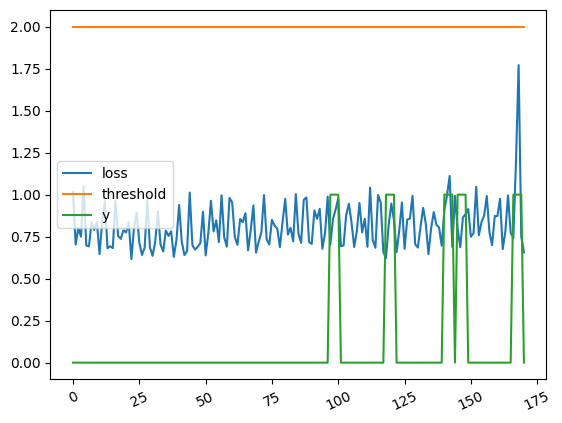

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 2 # Anomaly score threshold for an instance to be considered as anomaly 
#can set manually

#TIME_STEPS = dataset.window_length
test_score_df = pd.DataFrame(index=range(test_dataset.data_len))
test_score_df['loss'] = [loss.item()/test_dataset.window_length for loss in loss_list]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

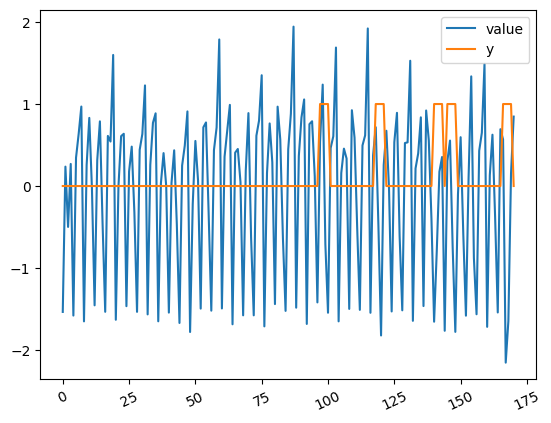

In [23]:
import seaborn as sns

anomalies = test_score_df[test_score_df.anomaly == True]

plt.plot(
  range(test_dataset.data_len), 
  test_score_df['t'], 
  label='value'
);
# ORIGINAL
# sns.scatterplot(
#   anomalies.index,
#   anomalies.t,
#   color=sns.color_palette()[3],
#   s=52,
#   label='anomaly'
# )

sns.scatterplot(
  x=anomalies.index,
  y=anomalies.t,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)

plt.plot(
  range(len(test_score_df['y'])),
  test_score_df['y'],
  label='y'
)

plt.xticks(rotation=25)
plt.legend();

In [24]:
import numpy as np
start_end = []
state = 0
for idx in test_score_df.index:
    if state==0 and test_score_df.loc[idx, 'y']==1:
        state=1
        start = idx
    if state==1 and test_score_df.loc[idx, 'y']==0:
        state = 0
        end = idx
        start_end.append((start, end))

for s_e in start_end:
    if sum(test_score_df[s_e[0]:s_e[1]+1]['anomaly'])>0:
        for i in range(s_e[0], s_e[1]+1):
            test_score_df.loc[i, 'anomaly'] = 1
            
actual = np.array(test_score_df['y'])
predicted = np.array([int(a) for a in test_score_df['anomaly']])

In [25]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

tp = np.count_nonzero(predicted * actual)
tn = np.count_nonzero((predicted - 1) * (actual - 1))
fp = np.count_nonzero(predicted * (actual - 1))
fn = np.count_nonzero((predicted - 1) * actual)

print('True Positive\t', tp)
print('True Negative\t', tn)
print('False Positive\t', fp)
print('False Negative\t', fn)

accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-9)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
fmeasure = (2 * precision * recall) / (precision + recall + 1e-9)
cohen_kappa_score = cohen_kappa_score(predicted, actual)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(actual, predicted)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f-measure\t', fmeasure)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)

True Positive	 0
True Negative	 151
False Positive	 0
False Negative	 20
Accuracy	 0.8830409356673506
Precision	 0.0
Recall	 0.0
f-measure	 0.0
cohen_kappa_score	 0.0
auc	 0.5
roc_auc	 0.5


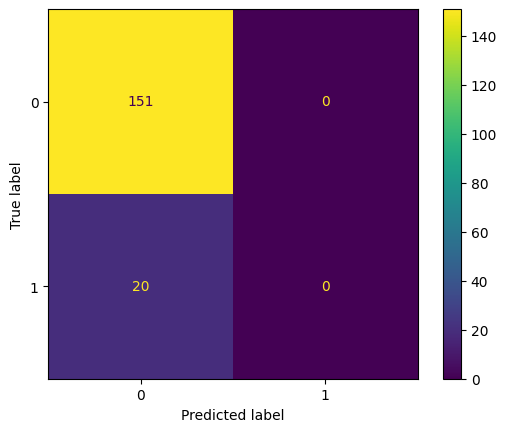

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actual, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()